In [51]:
'''data'''
import pandas as pd
import numpy as np
from datetime import datetime
import math


'''plotting'''
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
import seaborn as sns

'''sys library'''
#plt.style.use('fivethirtyeight')
import warnings
import os
import gc
warnings.filterwarnings('ignore')
%matplotlib inline
rc('font',family="NanumSquareR")

'''modeling'''
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
#from ggplot import *
from sklearn.linear_model import LinearRegression
import scipy.stats as st
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import uniform, randint
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
#-*- coding: utf-8 -*-

In [2]:
plt.style.use('ggplot') #ggplot스타일 사용
plt.rc('axes', unicode_minus=False)
rc('font', family='AppleGothic')

In [52]:
jeju_df = pd.read_csv('jeju_data_ver1/201901-202003.csv')

In [53]:
sub = pd.read_csv('jeju_data_ver1/submission.csv')

In [5]:
sub_rf = pd.read_csv('jeju_data_ver1/submission.csv')

In [6]:
sub_emb = pd.read_csv('jeju_data_ver1/submission.csv')

# ***Data Cleansing***

In [33]:
def data_wrangling(jeju_df):
    year_ls = []
    for i in jeju_df['REG_YYMM'].tolist():
        year_ls.append(int(str(i)[:4]))

    month_ls = []
    for i in jeju_df['REG_YYMM'].tolist():
        month_ls.append(int(str(i)[4:]))

    jeju_df['year'] = year_ls
    jeju_df['month'] = month_ls

    jeju_df.drop(columns = 'REG_YYMM',inplace = True)

    df = jeju_df.drop(columns = ['CARD_CCG_NM','HOM_CCG_NM'])

    columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
    df2 = df.groupby(columns).sum().reset_index(drop=False)

    # 인코딩
    dtypes = df2.dtypes
    encoders = {}
    for column in df2.columns:
        if str(dtypes[column]) == 'object':
            encoder = LabelEncoder()
            encoder.fit(df2[column])
            encoders[column] = encoder

    for column in encoders.keys():
        encoder = encoders[column]
        df2[column] = encoder.transform(df2[column])
        
    return encoders, df2

***4월 예측 데이터셋***

In [36]:
encoder_real, df2_real = data_wrangling(jeju_df)

***3월 예측 데이터셋***

In [63]:
jeju_df_remove3 = jeju_df[jeju_df['REG_YYMM'] != 202003]

In [64]:
encoder_remove3, df2_remove3 = data_wrangling(jeju_df_remove3)

# ***Default Modeling***

In [41]:
# 4월의 데이터를 예측하는 데이터
# 랜덤으로 샘플링(개수 그대로) - frac : 비율
train_num = df2_real.sample(frac=1, random_state=0)
train_df = train_num.drop(columns = ['CSTMR_CNT','AMT','CNT'])

# loglp -> 로그화를 통해서 데이터의 분포를 수정(왜도가 오른쪽이 긴 꼬리 분포)
target = np.log1p(train_num['AMT'])

In [65]:
# 3월 데이터를 검증셋으로 구축
train_num_remove3 = df2_remove3.sample(frac=1, random_state=0)
train_df_remove3 = train_num_remove3.drop(columns = ['CSTMR_CNT','AMT','CNT'])

# loglp -> 로그화를 통해서 데이터의 분포를 수정(왜도가 오른쪽이 긴 꼬리 분포)
target_remove3 = np.log1p(train_num_remove3['AMT'])

# ***LGBM***

In [42]:
# 예측 템플릿 만들기
# 예측 템플릿을 실예측 탬플릿, 검증셋 탬플릿을 나눠서 구분
def predict_temp(df,train_df,real_train = True):
    if real_train == False:
        CARD_SIDO_NMs = df['CARD_SIDO_NM'].unique()
        STD_CLSS_NMs  = df['STD_CLSS_NM'].unique()
        HOM_SIDO_NMs  = df['HOM_SIDO_NM'].unique()
        AGEs          = df['AGE'].unique()
        SEX_CTGO_CDs  = df['SEX_CTGO_CD'].unique()
        FLCs          = df['FLC'].unique()
        years         = [2020]
        months        = [3]

        temp = []
        for CARD_SIDO_NM in CARD_SIDO_NMs:
            for STD_CLSS_NM in STD_CLSS_NMs:
                for HOM_SIDO_NM in HOM_SIDO_NMs:
                    for AGE in AGEs:
                        for SEX_CTGO_CD in SEX_CTGO_CDs:
                            for FLC in FLCs:
                                for year in years:
                                    for month in months:
                                        temp.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
        temp = np.array(temp)
        temp_df = pd.DataFrame(data=temp, columns=train_df.columns)

        return temp_df
    
    elif real_train == True:
        
        CARD_SIDO_NMs = df['CARD_SIDO_NM'].unique()
        STD_CLSS_NMs  = df['STD_CLSS_NM'].unique()
        HOM_SIDO_NMs  = df['HOM_SIDO_NM'].unique()
        AGEs          = df['AGE'].unique()
        SEX_CTGO_CDs  = df['SEX_CTGO_CD'].unique()
        FLCs          = df['FLC'].unique()
        years         = [2020]
        months        = [4,7]

        temp = []
        for CARD_SIDO_NM in CARD_SIDO_NMs:
            for STD_CLSS_NM in STD_CLSS_NMs:
                for HOM_SIDO_NM in HOM_SIDO_NMs:
                    for AGE in AGEs:
                        for SEX_CTGO_CD in SEX_CTGO_CDs:
                            for FLC in FLCs:
                                for year in years:
                                    for month in months:
                                        temp.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
        temp = np.array(temp)
        temp_df = pd.DataFrame(data=temp, columns=train_df.columns)

        return temp_df
        

In [87]:
temp_remove3_lgb

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,AMT,REG_YYMM
0,0,0,0,1,1,1,2020,3,205587.0,202003
1,0,0,0,1,1,2,2020,3,31107.0,202003
2,0,0,0,1,1,3,2020,3,7294.0,202003
3,0,0,0,1,1,4,2020,3,17869.0,202003
4,0,0,0,1,1,5,2020,3,17883.0,202003
...,...,...,...,...,...,...,...,...,...,...
829425,16,30,14,0,2,1,2020,3,3292.0,202003
829426,16,30,14,0,2,2,2020,3,1634.0,202003
829427,16,30,14,0,2,3,2020,3,524.0,202003
829428,16,30,14,0,2,4,2020,3,599.0,202003


In [68]:
temp_remove3_lgb = predict_temp(df2_remove3, train_df_remove3,False)

In [56]:
temp_real_lgb = predict_temp(df2_real,train_df,True)

In [58]:
# 학습 : 교차검증
# LGBM 예측 (실 예측 or 검증셋 예측)
def lgb_Regressor(train_df, temp, target):
    
    folds = KFold(n_splits=5,random_state = 1001)

    sub_predict = np.zeros(temp.shape[0])
    oof_predict = np.zeros(train_df.shape[0])
    feature_importance_df = pd.DataFrame()

    for folds_, (train_idx,valid_idx) in enumerate(folds.split(train_df,target)):
        train_x, train_y = train_df.iloc[train_idx], target.iloc[train_idx]
        valid_x, valid_y = train_df.iloc[valid_idx], target.iloc[valid_idx]
        
        '''
        params = {
            'learning_rate' : 0.05,
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1
        }'''
        
        # 기존 파라미터 n_estimators = 5000, eval_metric = rmsle(평가 metric로 있는건가...) 이 상태 그대로
        # 학습량 5000까지 늘려서 검증해봐야겠다 근데 성능이 안좋을 것 같은게 처음에 완전 쌩 디폴트 파라미터로 제출한
        # lgbm모델의 성능이 더 좋았음
        reg = lgb.LGBMRegressor(random_state=0,n_estimators = 6000)

        reg.fit(train_x, train_y, eval_set = [(train_x, train_y), (valid_x, valid_y)],
               eval_metric='rmsle',verbose = 100)
        
        lgb.plot_metric(reg)
        plt.show()
        
        oof_predict[valid_idx] = reg.predict(valid_x,num_iteration = reg.best_iteration_)
        sub_predict += reg.predict(temp,num_iteration = reg.best_iteration_) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = train_df.columns
        fold_importance_df["importance"] = reg.feature_importances_
        fold_importance_df["fold"] = folds_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
    feature_importance_fin = feature_importance_df[["feature", "importance"]].\
                groupby("feature").mean().sort_values(by="importance", ascending=False)
    
    
    return sub_predict, oof_predict, feature_importance_fin

[100]	training's l2: 3.2505	valid_1's l2: 3.24134
[200]	training's l2: 2.46951	valid_1's l2: 2.4699
[300]	training's l2: 2.03566	valid_1's l2: 2.0427
[400]	training's l2: 1.76832	valid_1's l2: 1.77791
[500]	training's l2: 1.57819	valid_1's l2: 1.59012
[600]	training's l2: 1.43612	valid_1's l2: 1.44934
[700]	training's l2: 1.33316	valid_1's l2: 1.3483
[800]	training's l2: 1.2641	valid_1's l2: 1.28064
[900]	training's l2: 1.16838	valid_1's l2: 1.185
[1000]	training's l2: 1.07566	valid_1's l2: 1.09298
[1100]	training's l2: 1.01186	valid_1's l2: 1.02947
[1200]	training's l2: 0.962053	valid_1's l2: 0.98045
[1300]	training's l2: 0.914898	valid_1's l2: 0.93383
[1400]	training's l2: 0.878228	valid_1's l2: 0.898107
[1500]	training's l2: 0.842655	valid_1's l2: 0.862977
[1600]	training's l2: 0.814236	valid_1's l2: 0.835563
[1700]	training's l2: 0.792219	valid_1's l2: 0.814412
[1800]	training's l2: 0.76671	valid_1's l2: 0.789423
[1900]	training's l2: 0.739755	valid_1's l2: 0.763319
[2000]	training

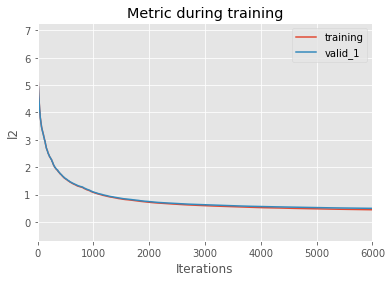

[100]	training's l2: 3.13365	valid_1's l2: 3.15761
[200]	training's l2: 2.39486	valid_1's l2: 2.41946
[300]	training's l2: 1.97673	valid_1's l2: 1.99993
[400]	training's l2: 1.72086	valid_1's l2: 1.74355
[500]	training's l2: 1.53471	valid_1's l2: 1.55791
[600]	training's l2: 1.39087	valid_1's l2: 1.41311
[700]	training's l2: 1.26606	valid_1's l2: 1.28765
[800]	training's l2: 1.16732	valid_1's l2: 1.18908
[900]	training's l2: 1.09237	valid_1's l2: 1.1142
[1000]	training's l2: 1.0305	valid_1's l2: 1.05278
[1100]	training's l2: 0.97631	valid_1's l2: 0.998785
[1200]	training's l2: 0.931848	valid_1's l2: 0.954788
[1300]	training's l2: 0.89427	valid_1's l2: 0.91756
[1400]	training's l2: 0.855177	valid_1's l2: 0.878766
[1500]	training's l2: 0.824355	valid_1's l2: 0.848631
[1600]	training's l2: 0.788255	valid_1's l2: 0.812413
[1700]	training's l2: 0.759973	valid_1's l2: 0.784563
[1800]	training's l2: 0.73737	valid_1's l2: 0.762456
[1900]	training's l2: 0.718663	valid_1's l2: 0.744312
[2000]	tr

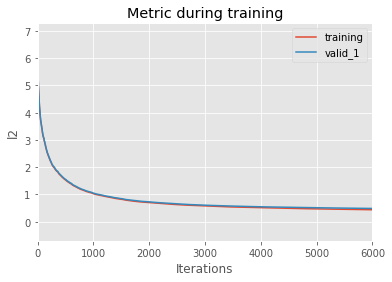

[100]	training's l2: 3.15395	valid_1's l2: 3.15737
[200]	training's l2: 2.50433	valid_1's l2: 2.51084
[300]	training's l2: 2.09261	valid_1's l2: 2.09907
[400]	training's l2: 1.81761	valid_1's l2: 1.8244
[500]	training's l2: 1.57126	valid_1's l2: 1.57921
[600]	training's l2: 1.39579	valid_1's l2: 1.40463
[700]	training's l2: 1.2608	valid_1's l2: 1.26989
[800]	training's l2: 1.17737	valid_1's l2: 1.18702
[900]	training's l2: 1.09347	valid_1's l2: 1.10394
[1000]	training's l2: 1.03236	valid_1's l2: 1.04442
[1100]	training's l2: 0.979533	valid_1's l2: 0.992525
[1200]	training's l2: 0.924248	valid_1's l2: 0.938696
[1300]	training's l2: 0.88339	valid_1's l2: 0.898758
[1400]	training's l2: 0.850342	valid_1's l2: 0.866437
[1500]	training's l2: 0.818017	valid_1's l2: 0.835183
[1600]	training's l2: 0.788627	valid_1's l2: 0.806633
[1700]	training's l2: 0.766694	valid_1's l2: 0.785767
[1800]	training's l2: 0.748023	valid_1's l2: 0.76775
[1900]	training's l2: 0.728869	valid_1's l2: 0.749404
[2000]	

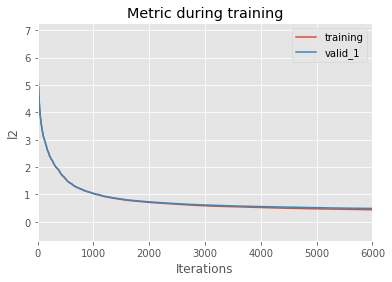

[100]	training's l2: 3.20579	valid_1's l2: 3.22099
[200]	training's l2: 2.3378	valid_1's l2: 2.34892
[300]	training's l2: 1.94392	valid_1's l2: 1.95834
[400]	training's l2: 1.68753	valid_1's l2: 1.70267
[500]	training's l2: 1.50182	valid_1's l2: 1.51872
[600]	training's l2: 1.38091	valid_1's l2: 1.39977
[700]	training's l2: 1.27382	valid_1's l2: 1.29441
[800]	training's l2: 1.19212	valid_1's l2: 1.21447
[900]	training's l2: 1.1203	valid_1's l2: 1.14352
[1000]	training's l2: 1.02847	valid_1's l2: 1.05099
[1100]	training's l2: 0.964442	valid_1's l2: 0.986867
[1200]	training's l2: 0.918913	valid_1's l2: 0.94125
[1300]	training's l2: 0.879103	valid_1's l2: 0.901932
[1400]	training's l2: 0.845138	valid_1's l2: 0.868191
[1500]	training's l2: 0.813429	valid_1's l2: 0.837242
[1600]	training's l2: 0.78485	valid_1's l2: 0.809371
[1700]	training's l2: 0.758643	valid_1's l2: 0.783954
[1800]	training's l2: 0.737558	valid_1's l2: 0.763393
[1900]	training's l2: 0.717847	valid_1's l2: 0.744131
[2000]	

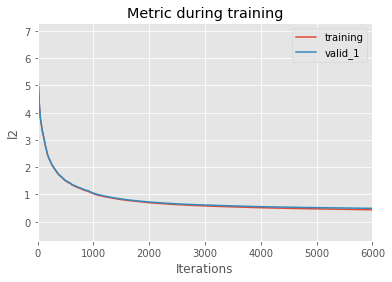

[100]	training's l2: 3.1892	valid_1's l2: 3.18525
[200]	training's l2: 2.45309	valid_1's l2: 2.45159
[300]	training's l2: 2.09051	valid_1's l2: 2.08995
[400]	training's l2: 1.8222	valid_1's l2: 1.82319
[500]	training's l2: 1.58118	valid_1's l2: 1.5835
[600]	training's l2: 1.44999	valid_1's l2: 1.45227
[700]	training's l2: 1.34529	valid_1's l2: 1.35001
[800]	training's l2: 1.25957	valid_1's l2: 1.26573
[900]	training's l2: 1.15636	valid_1's l2: 1.16425
[1000]	training's l2: 1.07315	valid_1's l2: 1.0828
[1100]	training's l2: 1.00215	valid_1's l2: 1.01285
[1200]	training's l2: 0.95307	valid_1's l2: 0.964736
[1300]	training's l2: 0.914682	valid_1's l2: 0.928006
[1400]	training's l2: 0.881031	valid_1's l2: 0.895401
[1500]	training's l2: 0.845375	valid_1's l2: 0.860994
[1600]	training's l2: 0.817813	valid_1's l2: 0.834657
[1700]	training's l2: 0.796477	valid_1's l2: 0.814549
[1800]	training's l2: 0.773325	valid_1's l2: 0.792588
[1900]	training's l2: 0.751104	valid_1's l2: 0.77111
[2000]	trai

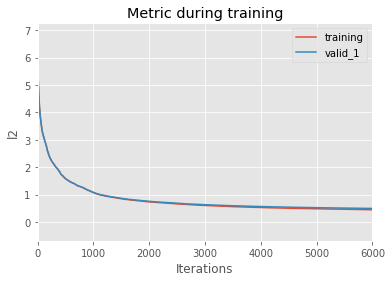

In [74]:
sub_lgb, oof_lgb,feature_importance_lgb = lgb_Regressor(train_df_remove3,
                                                        temp_remove3_lgb,
                                                        target_remove3)

[100]	training's l2: 3.21719	valid_1's l2: 3.20785
[200]	training's l2: 2.52127	valid_1's l2: 2.51341
[300]	training's l2: 2.10045	valid_1's l2: 2.09641
[400]	training's l2: 1.80947	valid_1's l2: 1.80855
[500]	training's l2: 1.60841	valid_1's l2: 1.60972
[600]	training's l2: 1.44806	valid_1's l2: 1.45132
[700]	training's l2: 1.33227	valid_1's l2: 1.33759
[800]	training's l2: 1.23294	valid_1's l2: 1.23968
[900]	training's l2: 1.15119	valid_1's l2: 1.15899
[1000]	training's l2: 1.06343	valid_1's l2: 1.0721
[1100]	training's l2: 1.00383	valid_1's l2: 1.0134
[1200]	training's l2: 0.957838	valid_1's l2: 0.968787
[1300]	training's l2: 0.917812	valid_1's l2: 0.929897
[1400]	training's l2: 0.879681	valid_1's l2: 0.892573
[1500]	training's l2: 0.843686	valid_1's l2: 0.857528
[1600]	training's l2: 0.813124	valid_1's l2: 0.82766
[1700]	training's l2: 0.788022	valid_1's l2: 0.803535
[1800]	training's l2: 0.763693	valid_1's l2: 0.779904
[1900]	training's l2: 0.745161	valid_1's l2: 0.76256
[2000]	tr

findfont: Font family ['NanumSquareR'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumSquareR'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumSquareR'] not found. Falling back to DejaVu Sans.


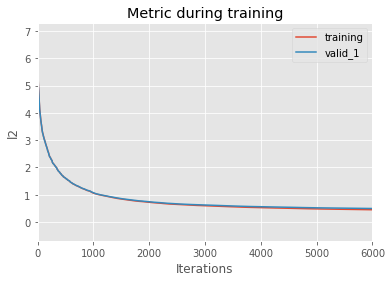

[100]	training's l2: 3.21092	valid_1's l2: 3.20928
[200]	training's l2: 2.45063	valid_1's l2: 2.45692
[300]	training's l2: 2.10702	valid_1's l2: 2.11577
[400]	training's l2: 1.77978	valid_1's l2: 1.78992
[500]	training's l2: 1.55225	valid_1's l2: 1.56403
[600]	training's l2: 1.42528	valid_1's l2: 1.43843
[700]	training's l2: 1.32373	valid_1's l2: 1.33778
[800]	training's l2: 1.21502	valid_1's l2: 1.23002
[900]	training's l2: 1.13219	valid_1's l2: 1.14803
[1000]	training's l2: 1.0622	valid_1's l2: 1.07857
[1100]	training's l2: 1.00888	valid_1's l2: 1.02565
[1200]	training's l2: 0.952092	valid_1's l2: 0.969476
[1300]	training's l2: 0.912123	valid_1's l2: 0.93037
[1400]	training's l2: 0.876559	valid_1's l2: 0.894778
[1500]	training's l2: 0.844223	valid_1's l2: 0.863327
[1600]	training's l2: 0.816612	valid_1's l2: 0.836238
[1700]	training's l2: 0.789755	valid_1's l2: 0.809979
[1800]	training's l2: 0.768984	valid_1's l2: 0.78977
[1900]	training's l2: 0.750234	valid_1's l2: 0.771779
[2000]	t

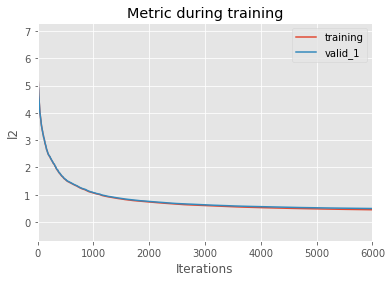

[100]	training's l2: 3.23951	valid_1's l2: 3.24772
[200]	training's l2: 2.53905	valid_1's l2: 2.55164
[300]	training's l2: 2.12028	valid_1's l2: 2.13638
[400]	training's l2: 1.84117	valid_1's l2: 1.85945
[500]	training's l2: 1.60953	valid_1's l2: 1.6299
[600]	training's l2: 1.44485	valid_1's l2: 1.46729
[700]	training's l2: 1.33886	valid_1's l2: 1.36153
[800]	training's l2: 1.22997	valid_1's l2: 1.25331
[900]	training's l2: 1.12958	valid_1's l2: 1.15372
[1000]	training's l2: 1.06254	valid_1's l2: 1.08714
[1100]	training's l2: 0.999275	valid_1's l2: 1.02447
[1200]	training's l2: 0.955412	valid_1's l2: 0.981122
[1300]	training's l2: 0.917841	valid_1's l2: 0.943799
[1400]	training's l2: 0.885458	valid_1's l2: 0.911634
[1500]	training's l2: 0.853331	valid_1's l2: 0.879215
[1600]	training's l2: 0.823516	valid_1's l2: 0.849671
[1700]	training's l2: 0.796521	valid_1's l2: 0.82304
[1800]	training's l2: 0.772018	valid_1's l2: 0.798501
[1900]	training's l2: 0.749702	valid_1's l2: 0.776384
[2000]

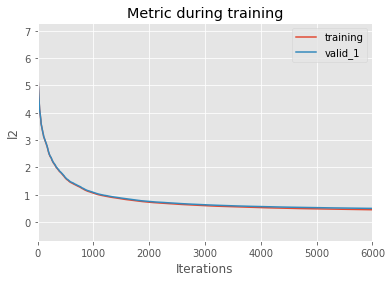

[100]	training's l2: 3.20359	valid_1's l2: 3.21102
[200]	training's l2: 2.44734	valid_1's l2: 2.45379
[300]	training's l2: 2.01818	valid_1's l2: 2.02527
[400]	training's l2: 1.78468	valid_1's l2: 1.79295
[500]	training's l2: 1.57269	valid_1's l2: 1.58172
[600]	training's l2: 1.46094	valid_1's l2: 1.47101
[700]	training's l2: 1.34534	valid_1's l2: 1.356
[800]	training's l2: 1.25444	valid_1's l2: 1.2662
[900]	training's l2: 1.17505	valid_1's l2: 1.1879
[1000]	training's l2: 1.10167	valid_1's l2: 1.1153
[1100]	training's l2: 1.03033	valid_1's l2: 1.0448
[1200]	training's l2: 0.975717	valid_1's l2: 0.990452
[1300]	training's l2: 0.926839	valid_1's l2: 0.942747
[1400]	training's l2: 0.890846	valid_1's l2: 0.907584
[1500]	training's l2: 0.85699	valid_1's l2: 0.87497
[1600]	training's l2: 0.82629	valid_1's l2: 0.845149
[1700]	training's l2: 0.802455	valid_1's l2: 0.822266
[1800]	training's l2: 0.780221	valid_1's l2: 0.801008
[1900]	training's l2: 0.758275	valid_1's l2: 0.779572
[2000]	trainin

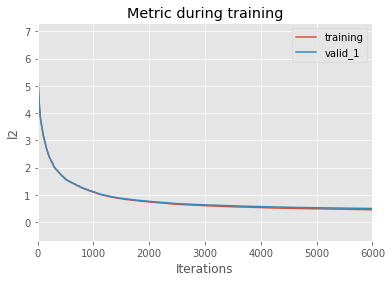

[100]	training's l2: 3.1828	valid_1's l2: 3.1984
[200]	training's l2: 2.51752	valid_1's l2: 2.5319
[300]	training's l2: 2.10796	valid_1's l2: 2.1226
[400]	training's l2: 1.88072	valid_1's l2: 1.89544
[500]	training's l2: 1.65224	valid_1's l2: 1.66663
[600]	training's l2: 1.45255	valid_1's l2: 1.46722
[700]	training's l2: 1.31335	valid_1's l2: 1.32795
[800]	training's l2: 1.20996	valid_1's l2: 1.22541
[900]	training's l2: 1.11377	valid_1's l2: 1.13061
[1000]	training's l2: 1.04232	valid_1's l2: 1.06016
[1100]	training's l2: 0.989754	valid_1's l2: 1.00787
[1200]	training's l2: 0.936846	valid_1's l2: 0.955638
[1300]	training's l2: 0.896231	valid_1's l2: 0.915706
[1400]	training's l2: 0.864277	valid_1's l2: 0.8845
[1500]	training's l2: 0.832317	valid_1's l2: 0.853432
[1600]	training's l2: 0.805078	valid_1's l2: 0.827274
[1700]	training's l2: 0.778702	valid_1's l2: 0.801134
[1800]	training's l2: 0.758317	valid_1's l2: 0.781501
[1900]	training's l2: 0.737322	valid_1's l2: 0.761068
[2000]	tra

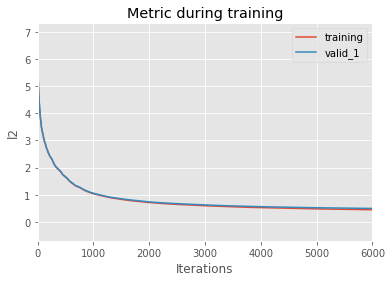

In [59]:
sub_lgb_real, oof_lgb_real,feature_importance_lgb_real = lgb_Regressor(train_df,
                                                        temp_real_lgb,
                                                        target)

# ***변수 중요도***

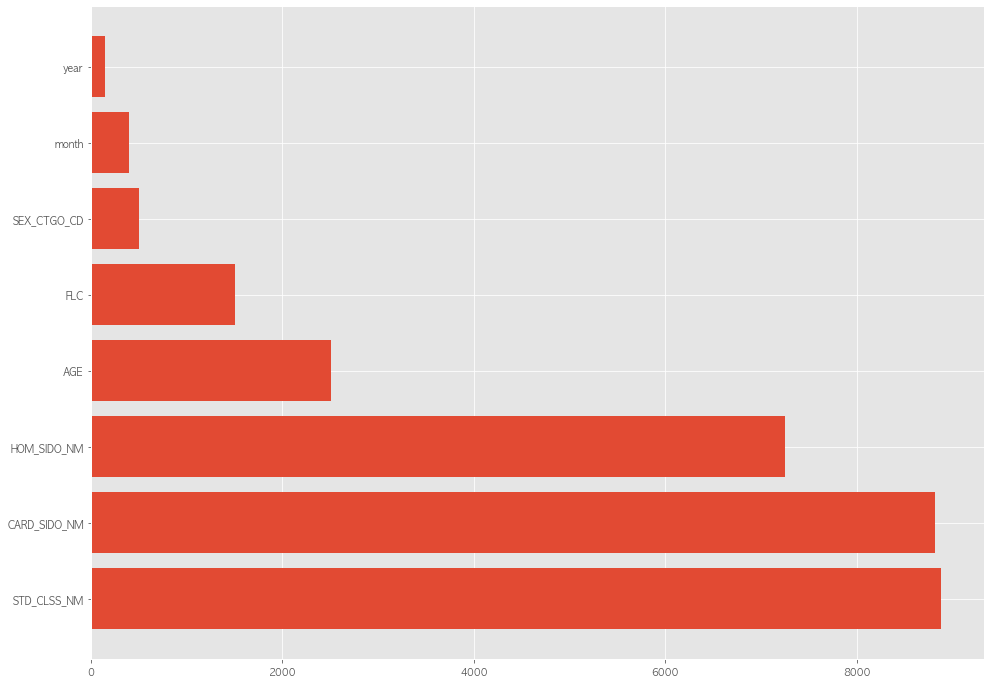

In [26]:
plt.figure(figsize = (16,12))
plt.barh(feature_importance_lgb_real.index,feature_importance_lgb_real['importance'])
plt.yticks(fontweight = 'bold')
plt.show()

# ***제출 및 검증 코드***

In [83]:
# 로컬에서 validation으로 검증할 것인지 or 실제 제출 파일을 만들 것인지?
def local_valid_function(sub,temp_df,sub_df,version_num,encoders,real_train = False):
    if real_train == False:
        pred = np.expm1(sub)
        temp_df['AMT'] = np.round(pred, 0)
        temp_df2 = temp_df
        temp_df['REG_YYMM'] = temp_df['year']*100 + temp_df['month']
        temp_df = temp_df[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
        temp_df = temp_df.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

        # 디코딩 
        temp_df['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp_df['CARD_SIDO_NM'])
        temp_df['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp_df['STD_CLSS_NM'])

        #test_valid3 = sub_df.drop(['AMT'], axis=1)
        #test_valid3 = test_valid3.merge(temp_remove3_lgb, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
        #test_valid3.index.name = 'id'
        #test_validation.drop(columns = 'id',inplace = True)
        #sub.to_csv('제출폴더/submission_version1.csv', encoding='utf-8-sig')
        #sub.head()
    
        return temp_df2 #test_valid3,
    
    elif real_train == True:
        
        pred = np.expm1(sub)
        temp_df['AMT'] = np.round(pred, 0)
        temp_df['REG_YYMM'] = temp_df['year']*100 + temp_df['month']
        temp_df = temp_df[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
        temp_df = temp_df.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

        # 디코딩 
        temp_df['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp_df['CARD_SIDO_NM'])
        temp_df['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp_df['STD_CLSS_NM'])

        sub = sub_df.drop(['AMT'], axis=1)
        sub = sub.merge(temp_df, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
        sub.index.name = 'id'
        try:
            sub.drop(columns = 'id',inplace = True)
        except:
            pass
        sub.to_csv('제출폴더/submission_version{}.csv'.format(version_num), encoding='utf-8-sig')
        #sub.head()
        
        return sub 

In [61]:
sub = local_valid_function(sub_lgb_real,temp_real_lgb,sub,6,encoder_real,True)

In [85]:
temp_df2 = local_valid_function(sub_lgb,temp_remove3_lgb,test_validation3,6,encoder_real,False)

In [337]:
RMSLE = np.sqrt(mean_squared_log_error(origin, test_valid3['AMT']))

In [338]:
RMSLE

1.306050435537303

# ***3월을 검증셋으로 테스트해보기***

### ***3월 데이터 검증 셋 구축***

In [77]:
test_validation0 = jeju_df.groupby(['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM'])['AMT'].sum().reset_index(name = 'AMT')

In [78]:
test_validation3 = test_validation0[test_validation0['REG_YYMM']==202003]

In [334]:
origin = test_validation3['AMT']

### ***3월 데이터와 2월 데이터의 RMSLE***

In [288]:
test_validation2 = test_validation0[test_validation0['REG_YYMM']==202002]

In [290]:
test_valid = pd.merge(test_validation,test_validation2.drop(columns = 'REG_YYMM'),on = ['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')

In [ ]:
test_valid2 = test_valid.dropna()

In [300]:
test_valid2 = test_valid.fillna(0)

In [301]:
RMSLE = np.sqrt(mean_squared_log_error(test_valid2['AMT_x'], test_valid2['AMT_y']))

In [302]:
RMSLE

1.068067060307771